In [16]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [17]:
# display 2016_stock_data.csv as dataframe
stock_df = pd.read_csv(
    Path("2016_stock_data.csv"), index_col="date", infer_datetime_format=True, parse_dates=True)
stock_df.head()

,AMZN,AAPL,NFLX
date,,,
2016-04-04,593.190002,25.877037,104.349998
2016-04-05,586.140015,25.571972,104.940002
2016-04-06,602.080017,25.839775,104.830002
2016-04-07,591.429993,25.276215,104.449997
2016-04-08,594.599976,25.304159,103.809998


In [18]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
amzn_df = stock_df.loc[:,["AMZN"]]
amzn_daily_returns = stock_df.AMZN.pct_change() * 100
amzn_df["Return"] = amzn_daily_returns
amzn_df = amzn_df.replace(-np.inf, np.nan).dropna()
amzn_df.to_csv(r'../Merged_data/amzn_returns.csv', index = True)
amzn_df.tail()

,AMZN,Return
date,,
2016-06-08,726.640015,0.400700
2016-06-09,727.650024,0.138997
2016-06-10,717.909973,-1.338563
2016-06-13,715.239990,-0.371911
2016-06-14,719.299988,0.567641


In [19]:
# Create a lagged return using the shift function
amzn_lag_return = amzn_df["Return"].shift()
amzn_df["Lagged Return"] = amzn_lag_return
amzn_df = amzn_df.replace(-np.inf, np.nan).dropna()
amzn_df.tail()

,AMZN,Return,Lagged Return
date,,,
2016-06-08,726.640015,0.400700,-0.411431
2016-06-09,727.650024,0.138997,0.400700
2016-06-10,717.909973,-1.338563,0.138997
2016-06-13,715.239990,-0.371911,-1.338563
2016-06-14,719.299988,0.567641,-0.371911


In [20]:
# Create a train/test split for the data using  for testing and the rest for training
amzn_train = amzn_df[:'2016-05-09']
amzn_test = amzn_df['2016-05-10':]

In [21]:
# Create four dataframes:
# X_amzn_train (training set using just the independent variables), X_amzn_test (test set of of just the independent variables)
# Y_amzn_train (training set using just the "y" variable), Y_amzn_test (test set of just the "y" variable):
X_amzn_train = amzn_train["Lagged Return"].to_frame()
X_amzn_test = amzn_test["Lagged Return"].to_frame()
y_amzn_train = amzn_train["Return"]
y_amzn_test = amzn_test["Return"]

In [22]:
# Preview the X_amzn_train data
X_amzn_train.head()

,Lagged Return
date,
2016-04-06,-1.188487
2016-04-07,2.719487
2016-04-08,-1.768872
2016-04-11,0.535986
2016-04-12,0.223683


In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
aapl_df = stock_df.loc[:,["AAPL"]]
aapl_daily_returns = stock_df.AAPL.pct_change() * 100
aapl_df["Return"] = aapl_daily_returns
aapl_df = aapl_df.replace(-np.inf, np.nan).dropna()
aapl_df.to_csv(r'../Merged_data/aapl_returns.csv', index = True)
aapl_df.tail()

,AAPL,Return
date,,
2016-06-08,23.180901,-0.090879
2016-06-09,23.347248,0.717606
2016-06-10,23.155132,-0.822863
2016-06-13,22.806034,-1.507649
2016-06-14,22.834148,0.123276


In [21]:
# Create a lagged return using the shift function
aapl_lag_return = aapl_df["Return"].shift()
aapl_df["Lagged Return"] = aapl_lag_return
aapl_df = aapl_df.replace(-np.inf, np.nan).dropna()
aapl_df.tail()

,AAPL,Return,Lagged Return
date,,,
2016-06-08,23.180901,-0.090879,0.405575
2016-06-09,23.347248,0.717606,-0.090879
2016-06-10,23.155132,-0.822863,0.717606
2016-06-13,22.806034,-1.507649,-0.822863
2016-06-14,22.834148,0.123276,-1.507649


In [22]:
# Create a train/test split for the data using  for testing and the rest for training
aapl_train = aapl_df[:'2016-05-09']
aapl_test = aapl_df['2016-05-10':]

In [23]:
# Create four dataframes:
# X_aapl_train (training set using just the independent variables), X_aapl_test (test set of of just the independent variables)
# Y_aapl_train (training set using just the "y" variable), Y_aapl_test (test set of just the "y" variable):
X_aapl_train = aapl_train["Lagged Return"].to_frame()
X_aapl_test = aapl_test["Lagged Return"].to_frame()
y_aapl_train = aapl_train["Return"]
y_aapl_test = aapl_test["Return"]

In [24]:
# Preview the X_aapl_train data
X_aapl_train.head()

,Lagged Return
date,
2016-04-06,-1.178903
2016-04-07,1.047253
2016-04-08,-2.180981
2016-04-11,0.110557
2016-04-12,0.331304


In [15]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
nflx_df = stock_df.loc[:,["NFLX"]]
nflx_daily_returns = stock_df.NFLX.pct_change() * 100
nflx_df["Return"] = nflx_daily_returns
nflx_df = nflx_df.replace(-np.inf, np.nan).dropna()
nflx_df.to_csv(r'../Merged_data/nflx_returns.csv', index = True)
nflx_df.tail()

,NFLX,Return
date,,
2016-06-08,97.860001,-2.032234
2016-06-09,97.089996,-0.786843
2016-06-10,93.750000,-3.440103
2016-06-13,93.849998,0.106665
2016-06-14,94.120003,0.287698


In [27]:
# Create a lagged return using the shift function
nflx_lag_return = nflx_df["Return"].shift()
nflx_df["Lagged Return"] = nflx_lag_return
nflx_df = nflx_df.replace(-np.inf, np.nan).dropna()
nflx_df.tail()

,NFLX,Return,Lagged Return
date,,,
2016-06-08,97.860001,-2.032234,-0.843755
2016-06-09,97.089996,-0.786843,-2.032234
2016-06-10,93.750000,-3.440103,-0.786843
2016-06-13,93.849998,0.106665,-3.440103
2016-06-14,94.120003,0.287698,0.106665


In [28]:
# Create a train/test split for the data using  for testing and the rest for training
nflx_train = nflx_df[:'2016-05-09']
nflx_test = nflx_df['2016-05-10':]

In [29]:
# Create four dataframes:
# X_nflx_train (training set using just the independent variables), X_nflx_test (test set of of just the independent variables)
# Y_nflx_train (training set using just the "y" variable), Y_nflx_test (test set of just the "y" variable):
X_nflx_train = nflx_train["Lagged Return"].to_frame()
X_nflx_test = nflx_test["Lagged Return"].to_frame()
y_nflx_train = nflx_train["Return"]
y_nflx_test = nflx_test["Return"]

In [30]:
# Preview the X_nflx_train data
X_nflx_train.head()

,Lagged Return
date,
2016-04-06,0.565409
2016-04-07,-0.104822
2016-04-08,-0.362496
2016-04-11,-0.612733
2016-04-12,-1.088524


In [31]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_amzn_train, Y_amzn_train):
amzn_model = LinearRegression()
amzn_model.fit(X_amzn_train, y_amzn_train)

# Fit a SKLearn linear regression using  just the training set (X_aapl_train, Y_aapl_train):
aapl_model = LinearRegression()
aapl_model.fit(X_aapl_train, y_aapl_train)

# Fit a SKLearn linear regression using  just the training set (X_nflx_train, Y_nflx_train):
nflx_model = LinearRegression()
nflx_model.fit(X_nflx_train, y_nflx_train)

LinearRegression()

In [32]:
# Make Amazon prediction of "y" values using just the test dataset
amzn_predictions = amzn_model.predict(X_amzn_test)

# Make Apple prediction of "y" values using just the test dataset
aapl_predictions = aapl_model.predict(X_aapl_test)

# Make Netflix prediction of "y" values using just the test dataset
nflx_predictions = nflx_model.predict(X_nflx_test)

In [33]:
# Assemble actual y data (Y_amzn_test) with predicted y data into two columns in a dataframe:
amzn_results = y_amzn_test.to_frame()
amzn_results["Predicted Return"] = amzn_predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ecb811310>,
      dtype=object)

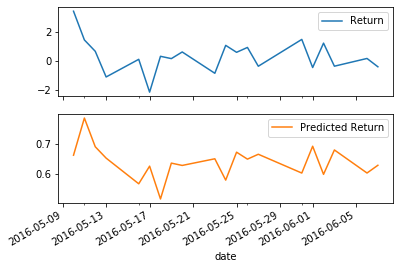

In [34]:
# Plot the first 20 Amazon predictions vs the true values
amzn_results[:20].plot(subplots=True)

In [35]:
# Assemble actual y data (Y_aapl_test) with predicted y data into two columns in a dataframe:
aapl_results = y_aapl_test.to_frame()
aapl_results["Predicted Return"] = aapl_predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ecb8ff940>,
      dtype=object)

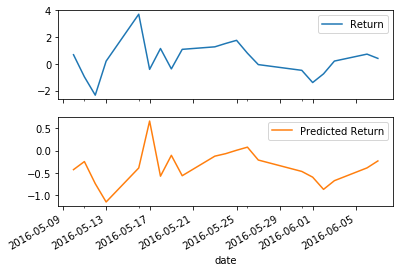

In [36]:
# Plot the first 20 Apple predictions vs the true values
aapl_results[:20].plot(subplots=True)

In [37]:
# Assemble actual y data (Y_nflx_test) with predicted y data into two columns in a dataframe:
nflx_results = y_nflx_test.to_frame()
nflx_results["Predicted Return"] = nflx_predictions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8ecba4fac0>,
      dtype=object)

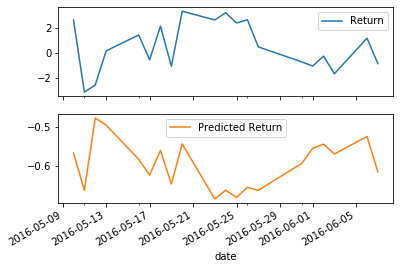

In [38]:
# Plot the first 20 Netflix predictions vs the true values
nflx_results[:20].plot(subplots=True)

In [39]:
# Out-of-Sample Performance
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
amzn_mse = mean_squared_error(
    amzn_results["Return"],
    amzn_results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
amzn_out_of_sample_rmse = np.sqrt(amzn_mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) for Amazon: {amzn_out_of_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE) for Amazon: 1.150242092230675


In [40]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
aapl_mse = mean_squared_error(
    aapl_results["Return"],
    aapl_results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
aapl_out_of_sample_rmse = np.sqrt(aapl_mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) for Apple: {aapl_out_of_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE) for Apple: 1.334836177455369


In [41]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
nflx_mse = mean_squared_error(
    nflx_results["Return"],
    nflx_results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
nflx_out_of_sample_rmse = np.sqrt(nflx_mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE) for Netflix: {nflx_out_of_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE) for Netflix: 2.0881334120179034


In [42]:
# In-Sample Performance
# Construct a dataframe using just the "y" training data:
amzn_in_sample_results = y_amzn_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
amzn_in_sample_results["In-sample Predictions"] = amzn_model.predict(X_amzn_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
amzn_in_sample_mse = mean_squared_error(
    amzn_in_sample_results["Return"],
    amzn_in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
amzn_in_sample_rmse = np.sqrt(amzn_in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE) for Amazon: {amzn_in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE) for Amazon: 2.4000373143554103


In [44]:
# Construct a dataframe using just the "y" training data:
aapl_in_sample_results = y_aapl_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
aapl_in_sample_results["In-sample Predictions"] = aapl_model.predict(X_aapl_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
aapl_in_sample_mse = mean_squared_error(
    aapl_in_sample_results["Return"],
    aapl_in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
aapl_in_sample_rmse = np.sqrt(aapl_in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE) for Apple: {aapl_in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE) for Apple: 1.5650738483449158


In [45]:
# Construct a dataframe using just the "y" training data:
nflx_in_sample_results = y_nflx_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
nflx_in_sample_results["In-sample Predictions"] = nflx_model.predict(X_nflx_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
nflx_in_sample_mse = mean_squared_error(
    nflx_in_sample_results["Return"],
    nflx_in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
nflx_in_sample_rmse = np.sqrt(nflx_in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE) for Netflix: {nflx_in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE) for Netflix: 3.1429642442216448
